In [72]:
import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy_ext as npe
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

import seaborn as sns

import sys

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins

In [73]:
scalers_dir = 'scalers/'
data_dir = 'data/'
seed = 4
np.random.seed(seed)
random.seed(seed)
all_var_types = [
    vital_sign_vars,
    lab_vars,
    treatment_vars,
    vent_vars,
    guideline_vars,
]
all_vars = functools.reduce(operator.add, all_var_types)

In [74]:
train_set = pd.read_csv(data_dir + 'train_imputed.csv')
clinical_train_scaler = joblib.load(scalers_dir + 'train/clinical_std_scaler.bin')
demographics_train_scaler = joblib.load(scalers_dir + 'train/demographics_std_scaler.bin')

test_set = pd.read_csv(data_dir + 'test_ffilled.csv')
val_set = pd.read_csv(data_dir + 'validation_ffilled.csv')

knn_imputer = joblib.load(scalers_dir + 'train/knn_imputer.bin')
scalers = {}
for var in all_vars + demographics:
    try:
        scalers[var] = joblib.load(scalers_dir + 'train/{}_std_scaler.bin'.format(var))
    except FileNotFoundError:
        pass

# TODO: FIX for test and validation sets: scaling (w/ train scaler?), knn imputation (w/ train clusterer), scaling (w/ train scaler?) and clustering (w/ train clusterer)
# for df in (test_set, val_set):
#     vars_to_impute = []
#     for var in all_vars:
#         if pd.api.types.is_numeric_dtype(df[var]):
#             ffilled = var + '_imp'
#             non_nas = df[~df[ffilled].isna()][ffilled].to_numpy().reshape(-1,1)
#             scaled = scalers[var].transform(non_nas)
#             scaledvarname = ffilled + '_scaled'
#             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
#             vars_to_impute.append(scaledvarname)
#     for var in demographics:
#         if pd.api.types.is_numeric_dtype(df[var]):
#             non_nas = df[~df[var].isna()][var].to_numpy().reshape(-1, 1)
#             scaled = scalers[var].transform(df[var].to_numpy().reshape(-1,1))
#             scaledvarname = var + '_scaled'
#             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
#             vars_to_impute.append(scaledvarname)
#     knn_imputed_vars = list(map(lambda x: x + '_impknn', vars_to_impute))
#     imputed = knn_imputer.transform(df[vars_to_impute].to_numpy())
#     df.loc[:, knn_imputed_vars] = imputed

In [75]:
# NOTE: these have not been rescaled after imputation
test_set.to_csv(data_dir + 'test_imputed.csv')
val_set.to_csv(data_dir + 'validation_imputed.csv')

In [76]:
var_to_state_var = {}
for var in all_vars + demographics:
    if var + '_imp_scaled_impknn' in train_set.columns:
        var_to_state_var[var] = var + '_imp_scaled_impknn'
    elif var + '_scaled_impknn' in train_set.columns:
        var_to_state_var[var] = var + '_scaled_impknn'
        
# TODO: validate if this contains all vars
state_variables = list(var_to_state_var.values())

In [77]:
longest_sv = max(map(len, state_variables))
for sv in state_variables:
    print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn              : -0.0023 0.2137 1.0400
sirs_imp_scaled_impknn              : 0.0078 -0.1052 0.9961
gcs_imp_scaled_impknn               : 0.0553 0.1325 1.0461
heartrate_imp_scaled_impknn         : 0.0029 -0.0568 1.0017
sysbp_imp_scaled_impknn             : -0.0235 -0.1482 0.9870
meanbp_imp_scaled_impknn            : -0.0121 -0.1202 0.9930
diasbp_imp_scaled_impknn            : -0.0065 -0.0906 0.9989
shockindex_imp_scaled_impknn        : 0.0187 -0.1056 1.0305
resprate_imp_scaled_impknn          : 0.0314 -0.0862 1.0066
spo2_imp_scaled_impknn              : -0.0648 0.1289 1.0770
tempc_imp_scaled_impknn             : -0.0387 -0.0445 0.9840
potassium_imp_scaled_impknn         : 0.0398 -0.0859 0.9847
sodium_imp_scaled_impknn            : -0.0246 -0.0767 0.9787
chloride_imp_scaled_impknn          : -0.0214 0.0176 0.9925
glucose_imp_scaled_impknn           : 0.0095 -0.1841 1.0040
bun_imp_scaled_impknn               : 0.0726 -0.2464 1.0587
creatinine_imp_scaled_impknn        

In [78]:
# NOTE: mirror the changes made here in the 'unscale' logic
rescaler = StandardScaler()

rescaled = rescaler.fit_transform(train_set[state_variables])
rs_state_varnames = [var + '_rescaled' for var in state_variables]
train_set[rs_state_varnames] = rescaled

rescaled_test = rescaler.transform(test_set[state_variables])
test_set[rs_state_varnames] = rescaled_test

In [79]:
n_states = 650 # according to Peine's paper
clusterer = KMeans(n_clusters=n_states)
train_clusters = clusterer.fit_predict(train_set[rs_state_varnames])
test_clusters = clusterer.predict(test_set[rs_state_varnames])

Text(0.5, 1.0, 'Train set state cluster distr')

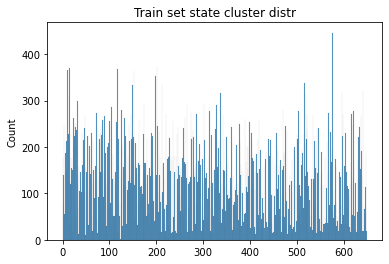

In [80]:
sns.histplot(train_clusters, bins=n_states)
plt.title('Train set state cluster distr')

Text(0.5, 1.0, 'Test set state cluster distr')

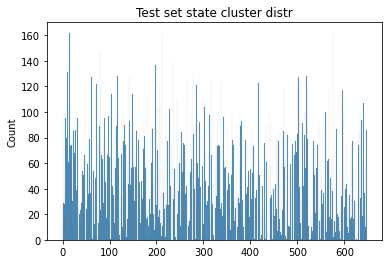

In [81]:
sns.histplot(test_clusters, bins=n_states)
plt.title('Test set state cluster distr')

In [82]:
clusters = pd.Series(train_clusters)
test_clusters_series = pd.Series(test_clusters)
clusters.value_counts()

576    446
201    375
14     369
117    367
10     366
      ... 
223      6
30       1
190      1
123      1
432      1
Length: 650, dtype: int64

In [83]:
longest_sv = max(map(len, rs_state_varnames))
for sv in rs_state_varnames:
    print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn_rescaled              : 0.0000 0.2118 1.0000
sirs_imp_scaled_impknn_rescaled              : -0.0000 -0.1132 1.0000
gcs_imp_scaled_impknn_rescaled               : 0.0000 0.0755 1.0000
heartrate_imp_scaled_impknn_rescaled         : -0.0000 -0.0597 1.0000
sysbp_imp_scaled_impknn_rescaled             : 0.0000 -0.1254 1.0000
meanbp_imp_scaled_impknn_rescaled            : -0.0000 -0.1085 1.0000
diasbp_imp_scaled_impknn_rescaled            : -0.0000 -0.0842 1.0000
shockindex_imp_scaled_impknn_rescaled        : -0.0000 -0.1224 1.0000
resprate_imp_scaled_impknn_rescaled          : -0.0000 -0.1172 1.0000
spo2_imp_scaled_impknn_rescaled              : -0.0000 0.1867 1.0000
tempc_imp_scaled_impknn_rescaled             : -0.0000 -0.0059 1.0000
potassium_imp_scaled_impknn_rescaled         : 0.0000 -0.1267 1.0000
sodium_imp_scaled_impknn_rescaled            : -0.0000 -0.0526 1.0000
chloride_imp_scaled_impknn_rescaled          : 0.0000 0.0392 1.0000
glucose_imp_scaled_impknn_res

In [84]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_set[rs_state_varnames])

/home/floris/anaconda3/envs/nb/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Clustering Result Train (k=650, rescaled, PCA)')

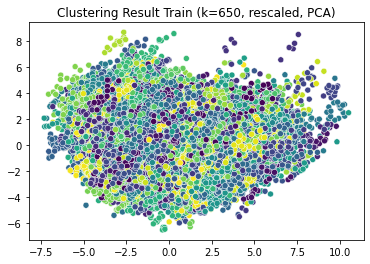

In [85]:
sns.scatterplot(pca_result[:,0], pca_result[:,1], c=train_clusters)
plt.title('Clustering Result Train (k={}, rescaled, PCA)'.format(n_states))

/home/floris/anaconda3/envs/nb/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Clustering Result Test (k=650, rescaled, PCA)')

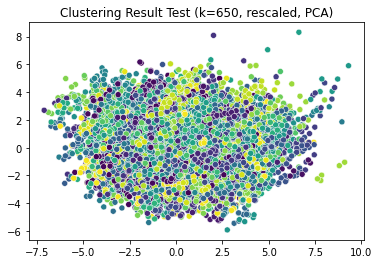

In [86]:
#pca = PCA(n_components=2)
#pca_result = pca.fit_transform(test_set[rs_state_varnames])
pca_result = pca.transform(test_set[rs_state_varnames])
sns.scatterplot(pca_result[:,0], pca_result[:,1], c=test_clusters)
plt.title('Clustering Result Test (k={}, rescaled, PCA)'.format(n_states))

In [87]:
print("""silhouette: {}, [-1, 1], higher is better
calinksi-harabasz: {}, higher is better
davies-bouldin: {}, [0, ∞], lower is better""".format(
    metrics.silhouette_score(train_set[rs_state_varnames], train_clusters),
    metrics.calinski_harabasz_score(train_set[rs_state_varnames], train_clusters),
    metrics.davies_bouldin_score(train_set[rs_state_varnames], train_clusters)))

silhouette: 0.05279710723242794, [-1, 1], higher is better
calinksi-harabasz: 162.15929401207515, higher is better
davies-bouldin: 2.3362740223921357, [0, ∞], lower is better


In [88]:
train_set['state'] = clusters
test_set['state'] = test_clusters_series

# Unscale - back to original and interpretable space

In [89]:
# This step is spurious for now, as there is no imputation after rescaling
un_rescaled_state_vars = rescaler.inverse_transform(train_set[rs_state_varnames])
un_rescaled_state_vars_test = rescaler.inverse_transform(test_set[rs_state_varnames])

clinical_scaled_varnames = [var + '_impknn' for var in joblib.load('scalers/train/clinical_std_varnames.bin')]
demographics_scaled_varnames = [var + '_impknn' for var in joblib.load('scalers/train/demographics_std_varnames.bin')]
unscaled_clinical_vars = clinical_train_scaler.inverse_transform(train_set[clinical_scaled_varnames])
unscaled_clinical_vars_test = clinical_train_scaler.inverse_transform(test_set[clinical_scaled_varnames])
unscaled_demo_vars = demographics_train_scaler.inverse_transform(train_set[demographics_scaled_varnames])
unscaled_demo_vars_test = demographics_train_scaler.inverse_transform(test_set[demographics_scaled_varnames])


unscaled_clinical_varnames = [var + '_unscaled' for var in clinical_scaled_varnames]
unscaled_demographics_varnames = [var + '_unscaled' for var in demographics_scaled_varnames]
train_set[unscaled_clinical_varnames] = unscaled_clinical_vars
test_set[unscaled_clinical_varnames] = unscaled_clinical_vars_test
train_set[unscaled_demographics_varnames] = unscaled_demo_vars
test_set[unscaled_demographics_varnames] = unscaled_demo_vars_test

In [90]:
# validation unscaling
#  * does not introduce NaNs
#  * does not change known values (by some error margin)
clinical_varname_pairs = list(zip(unscaled_clinical_varnames, map(lambda x: x.replace("_imp_scaled_impknn", ""), clinical_scaled_varnames)))
demo_varname_pairs = list(zip(unscaled_demographics_varnames, map(lambda x: x.replace("_scaled_impknn", ""), demographics_scaled_varnames)))
all_varname_pairs = clinical_varname_pairs + demo_varname_pairs
for (unscaled, original) in all_varname_pairs:
    print(unscaled, original)
    # check that the number of NaNs for unscaled is less or equal than original
    assert train_set[unscaled].isna().sum() <= train_set[original].isna().sum(), "Unscaling has introduced NaNs in train set"
    assert test_set[unscaled].isna().sum() <= test_set[original].isna().sum(), "Unscaling has introduced NaNs in test set"
    # calculate difference between unscaled and original value
    difference = np.absolute(train_set[~train_set[unscaled].isna()][unscaled] - train_set[~train_set[unscaled].isna()][original])
    difference_test = np.absolute(test_set[~test_set[unscaled].isna()][unscaled] - test_set[~test_set[unscaled].isna()][original])
    # difference should be small OR the original should be NaN.
    assert ((difference < 0.0001) | train_set[~train_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in train set".format(original)
    assert ((difference_test < 0.0001) | test_set[~test_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in test set".format(original)

sofa_imp_scaled_impknn_unscaled sofa
sirs_imp_scaled_impknn_unscaled sirs
gcs_imp_scaled_impknn_unscaled gcs
heartrate_imp_scaled_impknn_unscaled heartrate
sysbp_imp_scaled_impknn_unscaled sysbp
meanbp_imp_scaled_impknn_unscaled meanbp
diasbp_imp_scaled_impknn_unscaled diasbp
shockindex_imp_scaled_impknn_unscaled shockindex
resprate_imp_scaled_impknn_unscaled resprate
spo2_imp_scaled_impknn_unscaled spo2
tempc_imp_scaled_impknn_unscaled tempc
potassium_imp_scaled_impknn_unscaled potassium
sodium_imp_scaled_impknn_unscaled sodium
chloride_imp_scaled_impknn_unscaled chloride
glucose_imp_scaled_impknn_unscaled glucose
bun_imp_scaled_impknn_unscaled bun
creatinine_imp_scaled_impknn_unscaled creatinine
magnesium_imp_scaled_impknn_unscaled magnesium
calcium_imp_scaled_impknn_unscaled calcium
ionizedcalcium_imp_scaled_impknn_unscaled ionizedcalcium
carbondioxide_imp_scaled_impknn_unscaled carbondioxide
bilirubin_imp_scaled_impknn_unscaled bilirubin
albumin_imp_scaled_impknn_unscaled albumin
h

## Compute derived values
- normalized tidal volume: tv in ml/Kg of adult ideal body weight

In [91]:
# derived variables based on imputed / normalized values
# - tidal_volume
train_set['tv_derived'] = train_set['tidal_volume_imp_scaled_impknn_unscaled'] / train_set['admission_age_scaled_impknn_unscaled']
test_set['tv_derived'] = test_set['tidal_volume_imp_scaled_impknn_unscaled'] / test_set['admission_age_scaled_impknn_unscaled']

# Action space discretization
The action space consists of three dimensions:
* Tidal volume (ml/Kg), where Kg refers to the ideal body weight
* PEEP (cmH20) positive end-expiration pressure
* FiO2 (%) fraction of inspired oxygen

These three dimensions are each discretized into 7 bins, rendering a total of 7^3 = 343 actions.  
The action bins are defined per dimension and according to Peine in ``config.py``.
Here we map all possible actions to a discrete identifier action.

In [92]:
# a definition of all actions
action_bin_definition = list(itertools.product(tv_bins, fio2_bins, peep_bins))
# the lower bounds for the three variables in the action space
lower_bounds = [[var[0] for var in ranges] for ranges in action_bin_definition] 

def to_discrete_action(tidal_volume, fio2, peep, action_bin_definition=action_bin_definition):
    """
    Returns the action identifier for a particular combination of tv, fio2 and peep based on the bins defined in `action_bin_definition`.
    
    Assumes:
    * that the order of these variables in the definition is: tv_bin, fio2_bin, peep_bin,
    * that the ranges in the definition are defined as [lower bound, upper bound)
    TODO: speed up computation using hash lookups for ranges and vectorization with pandas?
    """
    for i, (tv_range, fio2_range, peep_range) in enumerate(action_bin_definition):
        # extract lower and upper bounds of all ranges
        tv_lb, fio2_lb, peep_lb = tv_range[0], fio2_range[0], peep_range[0]
        tv_ub, fio2_ub, peep_ub = tv_range[1], fio2_range[1], peep_range[1]
        if (tv_lb   <= tidal_volume < tv_ub and
            fio2_lb <= fio2         < fio2_ub and
            peep_lb <= peep         < peep_ub):
            # in range
            return i
    raise ValueError("Action (tv: {}, fio2:{}, peep:{}) not in action space".format(tidal_volume, fio2, peep))

def to_discrete_action_bins(action_id):
    tv_range, fio2_range, peep_range = action_bin_definition[action_id]
    tv_bin = tv_bins.index(tv_range)
    fio2_bin = fio2_bins.index(fio2_range)
    peep_bin = peep_bins.index(peep_range)
    return tv_bin, fio2_bin, peep_bin

def to_action_ranges(action_id):
    tv_bin, fio2_bin, peep_bin = to_discrete_action_bins(action_id)
    return tv_bins[tv_bin], fio2_bins[fio2_bin], peep_bins[peep_bin]

In [93]:
assert to_discrete_action(1, 25, 0) == 0, "the first action does not have id 0"             # the first action
assert to_discrete_action(1, 25, 5) == 1, "the second action does not have id 1"             # the second action
assert to_discrete_action(1, 25, sys.maxsize) == 6, "the last action in the third dimension does not have id 6"   # very high value for 3rd dimension (peep)
assert to_discrete_action(2.5, 25, 0) == 7*7, "the last action in the second dimension does not have id 7*7"         # second bin for the first dimension (tv)
assert to_discrete_action(sys.maxsize,
                          sys.maxsize,
                          sys.maxsize) == 7**3 - 1, "an action with very high values does not have id 7**3 -1"   # very high value for all bins

In [94]:
tv_clinical = 'tv_derived'
peep_clinical = 'peep_imp_scaled_impknn_unscaled'
fio2_clinical = 'fio2_imp_scaled_impknn_unscaled'

discretized_actions = train_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)
discretized_actions_test = test_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)

train_set['action_discrete'] = discretized_actions
test_set['action_discrete'] = discretized_actions_test

In [95]:
# sanity spot check -- do the sample values fall in the ranges?
train_set[[tv_clinical, peep_clinical, fio2_clinical]].iloc[0], discretized_actions[0], action_bin_definition[discretized_actions[0]]

(tv_derived                         10.482709
 peep_imp_scaled_impknn_unscaled     5.800000
 fio2_imp_scaled_impknn_unscaled    46.000000
 Name: 0, dtype: float64,
 225,
 ((10, 12.5), (45, 50), (5, 7)))

# Analysis of action and state-action distributions

In [96]:
observed_action_counts = discretized_actions.value_counts()
action_info = {}
action_counts = []
for action_id in range(len(action_bin_definition)):
    count = observed_action_counts[action_id] if action_id in observed_action_counts else 0
    action_info[action_id] = (action_bin_definition, count)
    action_counts.append(count)
action_counts = pd.Series(action_counts)

# possible actions: 343
actions never chosen: 115
most chosen action: (tv: (5, 7.5), peep:(40, 45), fio2: (5, 7)), chosen 9846 times


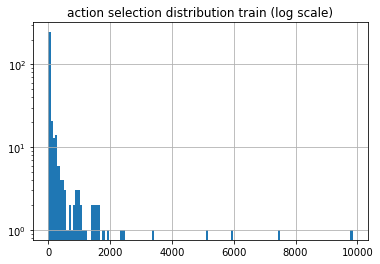

In [97]:
action_counts.hist(bins=action_counts.nunique(), log=True)
plt.title('action selection distribution train (log scale)')
print("# possible actions: {}".format(len(action_bin_definition)))
print("actions never chosen: {}".format((action_counts == 0).sum()))
most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions.value_counts().max()))

# possible actions: 343
actions never chosen: 146
most chosen action: (tv: (5, 7.5), peep:(40, 45), fio2: (5, 7)), chosen 3306 times


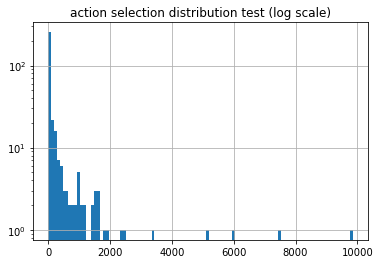

In [98]:
observed_action_counts_test = discretized_actions_test.value_counts()
action_info_test = {}
action_counts_test = []
for action_id in range(len(action_bin_definition)):
    count = observed_action_counts_test[action_id] if action_id in observed_action_counts_test else 0
    action_info_test[action_id] = (action_bin_definition, count)
    action_counts_test.append(count)
action_counts_test = pd.Series(action_counts_test)
action_counts.hist(bins=action_counts_test.nunique(), log=True)
plt.title('action selection distribution test (log scale)')
print("# possible actions: {}".format(len(action_bin_definition)))
print("actions never chosen: {}".format((action_counts_test == 0).sum()))
most_chosen_action = action_bin_definition[discretized_actions_test.mode()[0]]
print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions_test.value_counts().max()))

In [99]:
# state-action pair
state_actions = list(itertools.product(range(n_states), range(len(action_bin_definition)),))
print("{} states x {} actions = {} state-action pairs".format(n_states, len(action_bin_definition), len(state_actions)))
state_action_ids = list(map(lambda x: "{}-{}".format(x[0], x[1]), state_actions))

650 states x 343 actions = 222950 state-action pairs


In [100]:
train_set['terminal'] = False
train_set.loc[train_set.groupby('icustay_id').tail(1).index, 'terminal'] = True

train_set['state_action_id'] = train_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
train_set['next_state'] = train_set.state.astype(str).shift(-1)
# create special terminal states for both outcomes
terminal_mort = train_set['state'].max() + 1
terminal_nonmort = train_set['state'].max() + 2
        
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'next_state'] = terminal_mort
train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'next_state'] = terminal_nonmort

# State-Action-NextState_ID
train_set['sans_id'] = train_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
observed_saction_counts = train_set['state_action_id'].value_counts()
saction_info = {}
saction_counts = []
for i, saction_id in enumerate(state_action_ids):
    count = observed_saction_counts[saction_id] if saction_id in observed_saction_counts else 0
    state, action = saction_id.split('-')
    saction_info[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
    saction_counts.append(count)
saction_counts = pd.Series(saction_counts)
# saction_info

In [101]:
test_set['state_action_id'] = test_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
test_set['next_state'] = test_set.state.astype(str).shift(-1)
# State-Action-NextState_ID
test_set['sans_id'] = test_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
observed_saction_counts_test = test_set['state_action_id'].value_counts()
saction_info_test = {}
saction_counts_test = []
for i, saction_id in enumerate(state_action_ids):
    count = observed_saction_counts_test[saction_id] if saction_id in observed_saction_counts_test else 0
    state, action = saction_id.split('-')
    saction_info_test[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
    saction_counts_test.append(count)
saction_counts_test = pd.Series(saction_counts_test)
# saction_info_test

In [102]:
saction_info_df = pd.DataFrame([[*v,] for k, v in  saction_info.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])
saction_info_df_test = pd.DataFrame([[*v,] for k, v in  saction_info_test.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])

In [103]:
saction_info_df

,saction_id,index,count,state,action,action
0,0-0,0,0,0,0,"((0, 2.5), (20, 30), (0, 5))"
1,0-1,1,0,0,1,"((0, 2.5), (20, 30), (5, 7))"
2,0-2,2,0,0,2,"((0, 2.5), (20, 30), (7, 9))"
3,0-3,3,0,0,3,"((0, 2.5), (20, 30), (9, 11))"
4,0-4,4,0,0,4,"((0, 2.5), (20, 30), (11, 13))"
...,...,...,...,...,...,...
222945,649-338,222945,0,649,338,"((15, inf), (55, inf), (7, 9))"
222946,649-339,222946,0,649,339,"((15, inf), (55, inf), (9, 11))"
222947,649-340,222947,0,649,340,"((15, inf), (55, inf), (11, 13))"
222948,649-341,222948,0,649,341,"((15, inf), (55, inf), (13, 15))"


# state-action pairs: 222950
# state-action pairs never visited: 205734
most visited state-action pair in train: (tv: (5, 7.5), peep:(40, 45), fio2: (5, 7), state: 576), visited 187 times


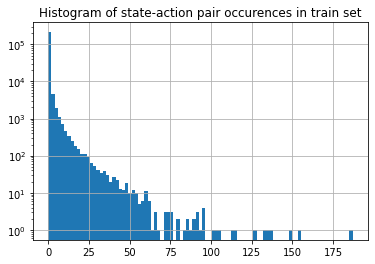

In [104]:
print("# state-action pairs: {}".format(len(state_action_ids)))
print("# state-action pairs never visited: {}".format((saction_counts == 0).sum()))
most_frequent_saction = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
saction_counts.hist(bins=saction_counts.nunique(), log=True)
plt.title("Histogram of state-action pair occurences in train set")
print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action, most_frequent_saction[3], most_frequent_saction[2]))

most visited state-action pair in train: (tv: (5, 7.5), peep:(40, 45), fio2: (5, 7), state: 576), visited 187 times


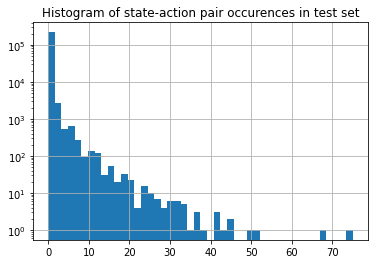

In [105]:
most_frequent_saction_test = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
most_chosen_action_test = action_bin_definition[discretized_actions.mode()[0]]
saction_counts_test.hist(bins=saction_counts_test.nunique(), log=True)
plt.title("Histogram of state-action pair occurences in test set")
print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action_test, most_frequent_saction_test[3], most_frequent_saction_test[2]))

## Trajectory construction

count    5335.000000
mean       15.849485
std         3.352275
min         7.000000
25%        14.000000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

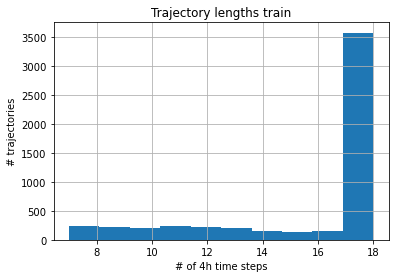

In [106]:
train_set['traj_count'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
train_set['traj_count_inv'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
train_set.groupby('icustay_id', as_index=False)['traj_count'].agg({'traj_len': 'max'})['traj_len']
train_set['traj_len'] = train_set.groupby('icustay_id', as_index=False)['traj_count'].transform(max)
train_set['traj_len'] += 1

trajectory_lengths = train_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths.hist()
plt.title('Trajectory lengths train')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths.describe()

count    1735.000000
mean       15.731412
std         3.461840
min         7.000000
25%        13.000000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

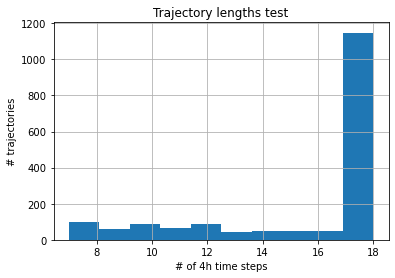

In [107]:
test_set['traj_count'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
test_set['traj_count_inv'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
test_set.groupby('icustay_id', as_index=False)['traj_count'].agg({'traj_len': 'max'})['traj_len']
test_set['traj_len'] = test_set.groupby('icustay_id', as_index=False)['traj_count'].transform(max)
test_set['traj_len'] += 1

trajectory_lengths_test = test_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths_test.hist()
plt.title('Trajectory lengths test')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths_test.describe()

In [108]:
terminals = train_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in train_set.columns:
    # need to remove this column if it already exists
    del(train_set['terminal'])
train_set = train_set.join(terminals, on='Unnamed: 0', how='left')
train_set['terminal'] = train_set.terminal.fillna(False)
train_set['nterminal'] = train_set.terminal.shift(-1).fillna(False)

terminals = test_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in test_set.columns:
    # need to remove this column if it already exists
    del(test_set['terminal'])
test_set = test_set.join(terminals, on='Unnamed: 0', how='left')
test_set['terminal'] = test_set.terminal.fillna(False)
test_set['nterminal'] = test_set.terminal.shift(-1).fillna(False)

In [109]:
assert train_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert train_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"

In [110]:
train_set[train_set.terminal][['next_state']]

,next_state
17,651
35,651
53,651
71,651
89,651
...,...
84484,651
84502,651
84520,651
84538,651


In [111]:
# TODO: fix trajectory definition, this should be more varied
# we include 72h samples. But what if the ventilation did not actually take that long?
# And why are trajectories either 1 (=4h) or 20 (=72h) time steps?
trajectory_lengths.value_counts(), trajectory_lengths_test.value_counts()

(18    3428
 11     233
 12     228
 9      218
 13     200
 10     199
 8      178
 14     153
 17     152
 16     150
 15     135
 7       61
 Name: traj_count, dtype: int64,
 18    1097
 10      85
 12      85
 8       79
 11      68
 9       60
 17      51
 15      48
 16      48
 14      47
 13      46
 7       21
 Name: traj_count, dtype: int64)

In [112]:
# generate s,s',a tuples for transition matrix approximation
  
# calculate joint state-action probabilities
pr_state_action = pd.DataFrame((train_set.state_action_id.value_counts() / train_set.shape[0])).reset_index().rename(columns={'index': 'sa_id', 'state_action_id': 'pr_sa'})


# calculate joint s-s'-a probabilities
sans_id = '' # state-action-nstate id
pr_nstate_state_action = pd.DataFrame(train_set.sans_id.value_counts() / train_set.shape[0]).reset_index().rename(columns={'index': 'sans_id', 'sans_id': 'pr_sans'})
pr_nstate_state_action['sa_id'] = list(map(lambda x: '-'.join(x[:2]), pr_nstate_state_action.sans_id.str.split('-')))
pr_sans = pr_nstate_state_action.merge(pr_state_action, on='sa_id', how='inner').set_index('sans_id')

# calculate transition probabilities
pr_trans = pr_sans.pr_sans / pr_sans.pr_sa
pr_trans = pd.DataFrame(pr_trans).rename(columns={0: 'pr_t'})



Text(0.5, 1.0, 'Distribution of nonzero transition probabilities')

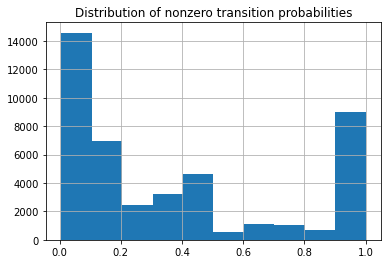

In [113]:
pr_trans.pr_t.hist()
pr_trans
plt.title('Distribution of nonzero transition probabilities')

In [114]:
split_sans = pd.DataFrame(pr_trans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_sans.state = split_sans.state.astype(int)
split_sans.action = split_sans.action.astype(int)
split_sans.nstate = split_sans.nstate.astype(int)
assert split_sans.action.max() <= (7**3 - 1), "the highest action id exceeds the number of actions" # number of discrete actions
pr_trans = pr_trans.reset_index().merge(split_sans, left_index=True, right_index=True)

In [115]:
split_sans[split_sans.nstate == 'nan']

,state,action,nstate


In [116]:
# all transition probabilities for a state-action pair should sum to 1, there could be some rounding errors
print("{:.5f}% of state-action's probs does not sum to 1, max diff to 1 is {}".format(
    (~(pr_trans.groupby(['state', 'action']).pr_t.sum() >= 1.0)).to_numpy().mean(),
    np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max(),
))
assert np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max() < 1e-15, "transition probabilities for a state-action pair should sum (approx.) to 1"

0.05878% of state-action's probs does not sum to 1, max diff to 1 is 4.440892098500626e-16


In [117]:
np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max()

4.440892098500626e-16

Text(0.5, 1.0, 'Histogram of nonzero transition probabilities')

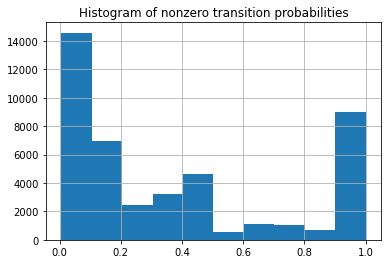

In [118]:
pr_trans.pr_t.hist()
plt.title('Histogram of nonzero transition probabilities')

In [119]:
# TODO: how to incorporate state-action pairs with no coverage in the dataset?

## Immediate reward definition

In [120]:
train_set['reward'] = 0
test_set['reward'] = 0
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'reward'] = -100
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'reward'] = -100
test_set.loc[test_set.terminal & (test_set.mort90day == 't'), 'reward'] = -100
train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'reward'] = 100
test_set.loc[test_set.terminal & (test_set.mort90day == 'f'), 'reward'] = 100

assert train_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert test_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert train_set[train_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"
assert test_set[test_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"

 0.0      39888
 100.0     2678
-100.0     1601
Name: reward, dtype: int64

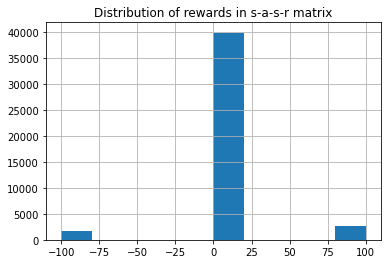

In [121]:
# 1. compute average immediate reward for each s-s'-a with support from the data.
# 2. where -100 if terminal and 90 day mortality, +100 if terminal and 90 day mortality, 0 otherwise
# 3. element-wise multiply with transition matrix pr_trans
# 4. sum over s' dimension to obtain R(s, a) < sum because transition matrix has probabilities

# step 1: compute average immediate reward for each s-s'-a with support from the data.
r_sans = train_set.groupby('sans_id')['reward'].mean()
r_sans.hist()
plt.title('Distribution of rewards in s-a-s-r matrix')
split_r_sans = pd.DataFrame(r_sans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_r_sans.state = split_r_sans.state.astype(int)
split_r_sans.action = split_r_sans.action.astype(int)
split_r_sans.nstate = split_r_sans.nstate
r_sans = r_sans.reset_index().merge(split_r_sans, left_index=True, right_index=True)
r_sans.reward.value_counts()

In [122]:
pr_r_sans = r_sans.merge(pr_trans, on='sans_id')
assert pr_r_sans.pr_t.isna().sum() == 0, "transition probabilities should never be na"
assert pr_r_sans.reward.isna().sum() == 0, "rewards should never be na"
assert pr_r_sans.shape[0] == r_sans.shape[0], "all reward rows should be in transition-reward dataframe"
assert pr_r_sans.shape[0] == pr_sans.shape[0], "all transition rows should be in transition-reward dataframe"
assert pr_r_sans.sans_id.value_counts().max() == 1, "a s-a-r-s tuple should occur exactly once"
assert pr_r_sans.sans_id.value_counts().min() == 1, "a s-a-r-s tuple should occur exactly once"

In [123]:
# step 3: element-wise multiply with transition matrix pr_trans
pr_r_sans['weighted_reward'] = pr_r_sans.reward * pr_r_sans.pr_t
immediate_reward = pr_r_sans.groupby(['state_x', 'action_x']).weighted_reward.sum()
immediate_reward = immediate_reward.reset_index().rename(columns={'state_x': 'state', 'action_x': 'action', 'weighted_reward': 'immediate_reward'})

 0.000000      13524
 100.000000      413
 50.000000       250
 33.333333       211
-100.000000      211
               ...  
-3.703704          1
 6.521739          1
-37.500000         1
 3.076923          1
 5.128205          1
Name: immediate_reward, Length: 264, dtype: int64

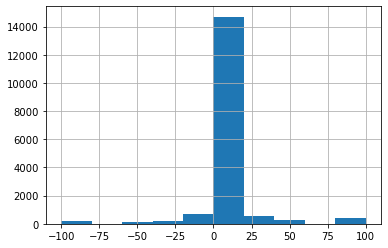

In [124]:
immediate_reward.immediate_reward.hist()
immediate_reward.immediate_reward.value_counts()

In [125]:
immediate_reward['state_action_id'] = immediate_reward.agg('{0[state]:.0f}-{0[action]:.0f}'.format, axis=1)

In [126]:
# train_set = train_set.merge(immediate_reward[['state_action_id', 'immediate_reward']], on='state_action_id')
# test_set = test_set.merge(immediate_reward[['state_action_id', 'immediate_reward']], on='state_action_id')

In [127]:
# assert train_set.immediate_reward.isna().sum() == 0, "Immediate reward may not be nan"
# assert test_set.immediate_reward.isna().sum() == 0, "Immediate reward may not be nan"

In [128]:
train_set[['sans_id', 'mort90day', 'terminal', 'next_state']]

,sans_id,mort90day,terminal,next_state
0,53-225-168,f,False,168
1,168-275-168,f,False,168
2,168-282-168,f,False,168
3,168-225-168,f,False,168
4,168-275-250,f,False,250
...,...,...,...,...
84552,155-337-155,f,False,155
84553,155-337-155,f,False,155
84554,155-337-155,f,False,155
84555,155-288-155,f,False,155


In [129]:
pr_trans[(pr_trans.state==0) & (pr_trans.action == 71)]

,sans_id,pr_t,state,action,nstate
36065,0-71-0,1.0,0,71,0


In [130]:
pr_sans[pr_sans.sa_id=='0-71']['pr_sa']

sans_id
0-71-0    0.000012
Name: pr_sa, dtype: float64

In [131]:
0.000332 * train_set.shape[0]

28.072924

In [132]:
pr_nstate_state_action.sans_id

0          47-316-47
1        576-120-576
2        152-120-152
3        521-120-521
4        147-120-147
            ...     
44162        52-71-2
44163      399-22-52
44164      52-71-399
44165      223-71-52
44166    155-330-651
Name: sans_id, Length: 44167, dtype: object

In [133]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,47-316-47,0.001336,47-316
1,576-120-576,0.001112,576-120
2,152-120-152,0.001053,152-120
3,521-120-521,0.000922,521-120
4,147-120-147,0.000887,147-120
...,...,...,...
44162,52-71-2,0.000012,52-71
44163,399-22-52,0.000012,399-22
44164,52-71-399,0.000012,52-71
44165,223-71-52,0.000012,223-71


In [134]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,47-316-47,0.001336,47-316
1,576-120-576,0.001112,576-120
2,152-120-152,0.001053,152-120
3,521-120-521,0.000922,521-120
4,147-120-147,0.000887,147-120
...,...,...,...
44162,52-71-2,0.000012,52-71
44163,399-22-52,0.000012,399-22
44164,52-71-399,0.000012,52-71
44165,223-71-52,0.000012,223-71


In [185]:
(train_set.icustay_id == 299994).any()

False

In [186]:
test_set.to_csv('data/test_unshaped_traj.csv')
train_set.to_csv('data/train_unshaped_traj.csv')

# Training a policy

In [136]:
immediate_reward[['state', 'action', 'immediate_reward']]
# matrix of immediate rewards
sar = np.full((n_states, 7**3), np.nan)
for state, action, reward in immediate_reward[['state', 'action', 'immediate_reward']].to_numpy():
    sar[int(state), int(action)] = reward

# Qn = {} # maps n to q tables

In [137]:
np.nanmax(sar[0, :])

100.0

In [138]:
# According to the tabular FQI algorithm in Ernst, Geurts & Wehenkel (2005), Figure 1
# and Peine's supplementary discussion "A: Evaluation of Policies".
def peine_mc_iterate(snsasr, r, Qn, gamma, n_epochs=1, learning_rate=0.1):
    """
    Monte-carlo-based iteration of the training procedure according to tabular FQI & Peine's supplementary discussion.
    
    snsas: numpy ndarray with discretized state-nextstate-action tuples
    r: a function that returns the immediate reward for a state-action pair
    Qn: dictionary that maps iteration indices to Qn-estimates
    n: iteration number
    gamma: discount factor
    n_epochs: number of times to iterate over dataset
    learning rate: learning rate alpha
    """
    def epoch(snsasr, r, Qn, gamma, learning_rate):
        for i, (s, ns, a, er) in enumerate(snsasr):
            Qn[s,a] = Qn[s,a] + learning_rate * (er + gamma * np.max(Qn[int(ns),:]) - Qn[s,a])
        return Qn
    assert Qn.shape == (n_states+2, 7**3)
    for n in range(n_epochs):
        Qn = epoch(snsasr, r, Qn, gamma, learning_rate)
        print('.', end='')
    return Qn


def ernst_iterate(snsasr, Qn, n, gamma, regressor, action_space, state_repr=None, action_repr=to_discrete_action_bins):
    """
    snsas: numpy ndarray with discretized state_id-nextstate_id-action_id tuples
    r: immediate rewards
    Qn: dictionary that maps iteration indices to Qn estimates/estimators
    n: iteration number
    gamma: discount factor
    regression: sklearn regression class
    action_space: iterator that retuns all actions in
    action_repr: function that returns the action representation
    """
    def batches(X, batch_size):
        n_batches = int(math.ceil(X.shape[0] / batch_size))
        batches = []
        for i in range(n_batches):
            batch_start = i * batch_size
            batch_end = min(batch_start + batch_size, X.shape[0])
            batches.append((batch_start, batch_end))
        return batches

    def prediction_set(X, action_space):
        shape_x = X.shape
        n_actions = action_space.shape[0]
        action_dims = action_space.shape[1]
        repeated_X = X.repeat(n_actions, axis=0).reshape((shape_x[0] * n_actions, shape_x[1]))
        repeated_action_reprs = np.tile(action_space, (shape_x[0], 1)).reshape(repeated_X.shape[0], action_dims)
        return np.concatenate([repeated_X, repeated_action_reprs], axis=1)

    Q_hat = Qn[n]
    n = n + 1
    # terminal states only
    snsasr_t = snsasr[snsasr[:,1] >= 650] # 650 = number of non-terminal states
    r_t = snsasr_t[:, 3]
    # non-terminal states only
    snsasr = snsasr[snsasr[:,1] < 650] # 650 = number of non-terminal states
    a_reprs = np.array(list(map(action_repr, snsasr[:,2])))
    action_space_reprs = np.array(list(map(action_repr, action_space)))
    s_reprs = state_repr.transform(snsasr[:, 0].reshape(-1, 1))
    ns_reprs = state_repr.transform(snsasr[:, 1].reshape(-1, 1))
    r = snsasr[:, 3]
    X_train = hstack((s_reprs, a_reprs))
    # generate prediction dataset of length X.shape[0] * len(action_space)
    batch_size = int(X_train.shape[0] / 100)
    y_train = np.array([])
    for batch_start, batch_end in batches(X_train, batch_size):
        X_batch = ns_reprs[batch_start:batch_end, :].toarray()
        X_preds = prediction_set(X_batch, action_space_reprs)
        # predict Q scores for prediction dataset
        y_preds = Q_hat.predict(X_preds)
        # create targets with immediate reward and highest Q score for each row
        y_preds = y_preds.reshape(X_batch.shape[0], len(action_space_reprs))
        y_train = np.concatenate([y_train, r[batch_start:batch_end] + gamma * y_preds.max(axis=1)], axis=0)
        print('.', end ='')
    # terminal states
    a_reprs_t = np.array(list(map(action_repr, snsasr_t[:,2])))
    s_reprs_t = state_repr.transform(snsasr_t[:, 0].reshape(-1, 1))
    X_train_t = hstack((s_reprs_t, a_reprs_t))
    y_train_t = r_t
    print("y_train_t {}".format(y_train_t.shape))
    X_train_n = vstack((X_train_t, X_train))
    print("y_train {}".format(y_train.shape))
    y_train = np.concatenate((y_train, y_train_t))
    print("y_train {}".format(y_train.shape))
    print("X_train_n {}".format(X_train_n.shape))
    Q_hat_new = regressor()
    Q_hat_new.fit(X_train_n, y_train)
    return n, Q_hat_new


# TODO
# implement a regressor that wraps an OLS regressor in the following way:
#  1. creates an OLS regressor for each state
#  2. implements a predict() function that first looks up the right state OLS
#     and then calls predict() on the regressor there with the action levels as input
#  3. implements a fit() function that first segments X into buckets with the same state-action pair
#     then creates a regressor for that pair
#     and calls fit() on that pair << TODO: BUT GIVEN WHAT INPUT? does this only work for a three-dimensional action input?
class PerStateActionOLS():
    def __init__(self, states, default=None):
        self.regressors = {
            state: LinearRegression() for state in states
        }
        self.default = default
        
    def fit(self, X, y, states):
        """
        Fits a set of 
        """
        assert len(X) == len(states) == len(y), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        X_df.loc[:, 'y'] = y
        groups = X_df.groupby('state')
        for k in groups.groups.keys():
            X_group = groups.get_group(k)[X_cols].to_numpy()
            y_group = groups.get_group(k)['y'].to_numpy()
            self.regressors[k].fit(X_group, y_group)
    
    def predict(self, X, states):
        def predict_single(row, X_cols):
            if row.state in self.regressors.keys():
                return self.regressors[row.state].predict(row[X_cols].to_numpy().reshape(1,-1))
            else:
                if self.default is None:
                    raise ValueError('Cannot predict for state {} without default prediction.'.format(row.state))
                else:
                    return self.default
            
        if isinstance(X, Iterable):
            assert len(X) == len(states), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        predictions = X_df.apply(lambda x: predict_single(x, X_cols), axis=1)
        return predictions

class OneHotStateActionOLS():
    def __init__(self, obs_states, all_states=range(650), *args, **kwargs):
        # TODO: ensure that all states are passed
        if type(obs_states) == set:
            obs_states = list(obs_states)
        obs_states = np.array(obs_states).reshape(-1, 1)
        self.state_encoder = OneHotEncoder(categories=[all_states,]).fit(obs_states)
        self.regressor = LinearRegression()
    
    def encode(self, X, states):
        state_encoding = self.state_encoder.transform(states)
        return np.concatenate((X, state_encoding.todense()), axis=1)

    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        X = np.array(X)
        states = np.array(states).reshape(-1, 1)
        X_new = self.encode(X, states)
        return self.regressor.predict(X_new)


class DummyRegressor:
    def __init__(self, return_val=0):
        self.return_val = return_val
        
    def predict(self, X, *args, **kwargs):
        return np.repeat([self.return_val], X.shape[0]).reshape(-1, 1)

In [139]:
q_init_val = 0
q_init = np.full((n_states + 2, 7**3), float(q_init_val))
#  peine_mc_iterate(snsas, r, Qn, gamma, n_epochs=1, learning_rate=0.1):
q_mcp = peine_mc_iterate(
    # TODO: why are the NaNs here? how to deal with these?
    snsasr=train_set[['state', 'next_state', 'action_discrete', 'reward']].astype(int).to_numpy(),
    r=sar,
    Qn=q_init,
    gamma=0.99,
    n_epochs=10000,
    learning_rate=0.01,
)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

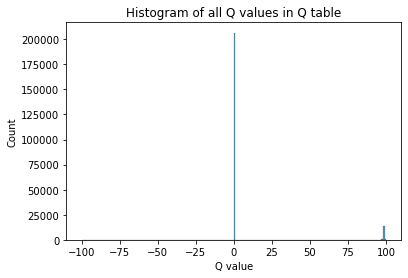

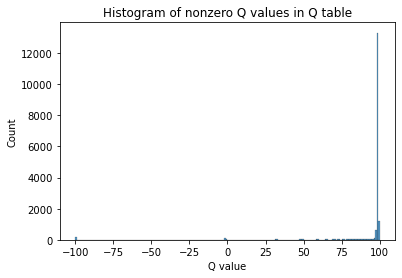

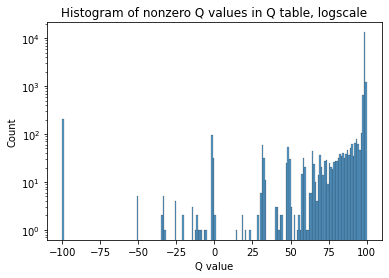

In [140]:
q_mcp_nan = q_mcp.copy()[:n_states, :]
q_mcp_nan[q_mcp_nan == 0.0] = np.nan
sns.histplot(q_mcp.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of all Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table, logscale')
plt.show()

In [141]:
joblib.dump(
    {'hyperparameters': {
        'Q_init': q_init,
        'gamma': 0.99,
        'n_epochs': 10000,
        'learning_rate': 0.01,
        'shaping': False,
    },
    'model': q_mcp_nan,
    },
    'models/peine_mc_unshaped_q_table.bin',
    compress=True
)

['models/peine_mc_unshaped_q_table.bin']

In [142]:
# derive policy by taking argmax over non-nan q values
# policy_mcp = np.full()
best_action_indices = np.nanargmax(q_mcp_nan, axis=1)

action_index_grid = np.tile(np.array(range(7**3)), 650).reshape((650, 7**3))
best_action_grid = np.repeat(best_action_indices, 7**3).reshape((650, 7**3))
best_action_bool = best_action_grid == action_index_grid
assert best_action_bool.shape == (n_states, 7**3)
assert (best_action_bool.sum(axis=1) == 1).all()
mcp_greedy = best_action_bool.astype(float)
assert (mcp_greedy.sum(axis=1) == 1).all()

In [201]:
# derive policy by taking softmax
q_mcp_neg = q_mcp.copy()[:n_states, :]
q_mcp_neg[q_mcp_neg == 0.0] = float('-inf')
mcp_softmax = scipy.special.softmax(q_mcp_neg, axis=1)
assert mcp_softmax.shape == (n_states, 7**3)
assert (mcp_greedy.sum(axis=1) == 1).all()

Global highest Q value 99.99999999999929 for tv, fio2, peep ranges: ((7.5, 10), (30, 35), (5, 7))
Highest avg Q value across states 99.99999999999929 for tv, fio2, peep ranges: ((0, 2.5), (35, 40), (5, 7))
Highest median Q value across states 15 for tv, fio2, peep ranges: ((0, 2.5), (35, 40), (5, 7))


<ipython-input-143-33b3a3ddbbfa>:3: RuntimeWarning: Mean of empty slice
  best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
/home/floris/anaconda3/envs/nb/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


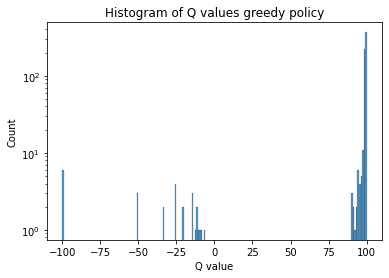

In [143]:
best_s, best_a = np.unravel_index(np.nanargmax(q_mcp_nan), (n_states, 7**3))
print("Global highest Q value {} for tv, fio2, peep ranges: {}".format(q_mcp_nan[best_s, best_a], to_action_ranges(best_a)))
best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
print("Highest avg Q value across states {} for tv, fio2, peep ranges: {}".format(best_mean_a_q, to_action_ranges(best_mean_a)))
best_med_a, best_med_a_q = np.nanargmax(np.nanmedian(q_mcp_nan, axis=0)), np.nanmax(np.nanmedian(q_mcp_nan, axis=0))
print("Highest median Q value across states {} for tv, fio2, peep ranges: {}".format(best_med_a, to_action_ranges(best_med_a)))
sns.histplot(q_mcp_nan[mcp_greedy == 1.0].ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of Q values greedy policy')
plt.show()

In [144]:
train_set['positive_outcome'] = train_set['mort90day'] == 'f'
estimated_mort_state_visit = train_set.groupby('state').mean('positive_outcome')[['positive_outcome']].to_numpy()

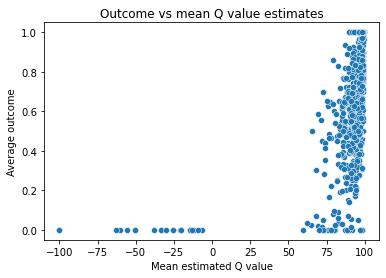

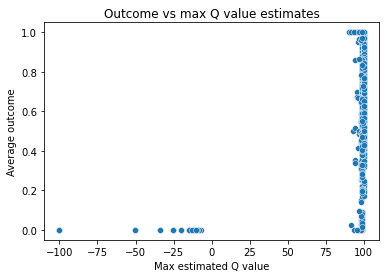

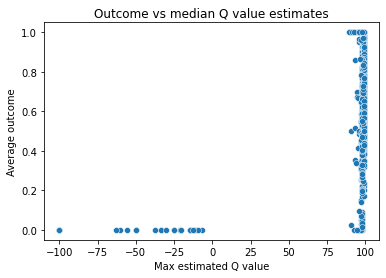

In [145]:
sns.scatterplot(x=np.nanmean(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Mean estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs mean Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmax(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs max Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmedian(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs median Q value estimates')
plt.show()

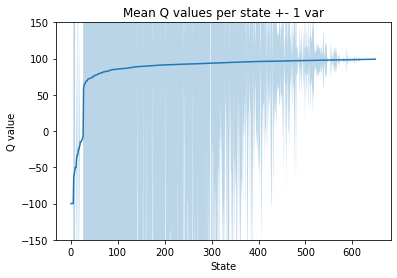

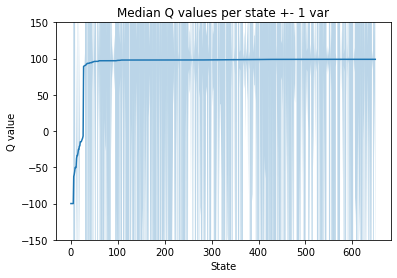

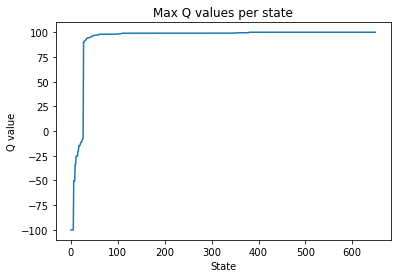

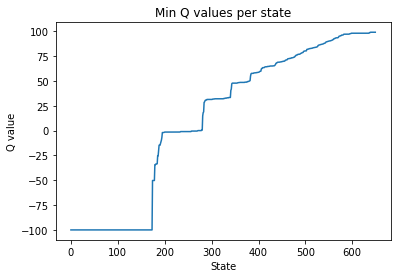

In [146]:
q_vars = np.nanvar(q_mcp_nan, axis=1)
q_means = np.nanmean(q_mcp_nan, axis=1)
q_medians = np.nanmedian(q_mcp_nan, axis=1)
q_maxs = np.nanmax(q_mcp_nan, axis=1)
q_mins = np.nanmin(q_mcp_nan, axis=1)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(n_states)
means_sorted = np.array(sorted(stacked, key=lambda x: x[0]))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per state +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: x[1]))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per state +- 1 var')
plt.show()

maxs_sorted = np.array(sorted(stacked, key=lambda x: x[2]))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per state')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: x[3]))
axs = sns.lineplot(x=xs, y=mins_sorted[:, 3])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per state')
plt.show()

<ipython-input-147-2b7f8cf21ad4>:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  q_vars = np.nanvar(q_mcp_nan, axis=0)
<ipython-input-147-2b7f8cf21ad4>:5: RuntimeWarning: Mean of empty slice
  q_means = np.nanmean(q_mcp_nan, axis=0)
/home/floris/anaconda3/envs/nb/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
<ipython-input-147-2b7f8cf21ad4>:7: RuntimeWarning: All-NaN slice encountered
  q_maxs = np.nanmax(q_mcp_nan, axis=0)
<ipython-input-147-2b7f8cf21ad4>:8: RuntimeWarning: All-NaN slice encountered
  q_mins = np.nanmin(q_mcp_nan, axis=0)


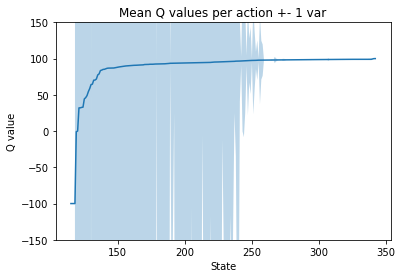

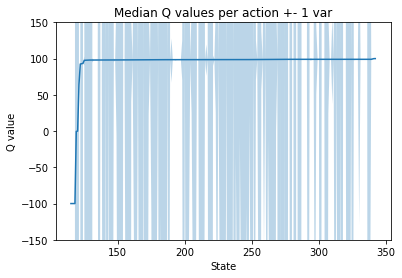

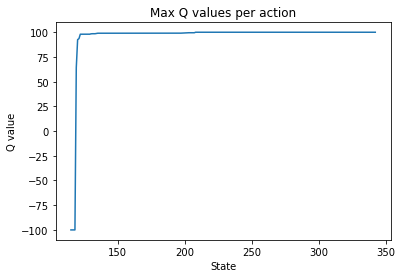

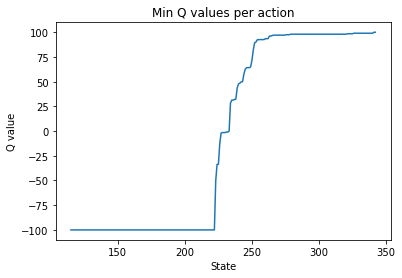

In [147]:
def sortnan(x, index):
    return float('-inf') if np.isnan(x[index]) else x[index]

q_vars = np.nanvar(q_mcp_nan, axis=0)
q_means = np.nanmean(q_mcp_nan, axis=0)
q_medians = np.nanmedian(q_mcp_nan, axis=0)
q_maxs = np.nanmax(q_mcp_nan, axis=0)
q_mins = np.nanmin(q_mcp_nan, axis=0)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(7**3)
means_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 0)))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per action +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 1)))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per action +- 1 var')
plt.show()

maxs_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 2)))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per action')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 3)))
axs = sns.lineplot(x=xs, y=mins_sorted[:, 3])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per action')
plt.show()

In [148]:
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

In [149]:
behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"

<ipython-input-149-10c77140ded8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
<ipython-input-149-10c77140ded8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
<ipython-input-149-10c77140ded8>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [167]:
train_set.loc[[27289]][['action_discrete', 'state']]

,action_discrete,state
27289,337,212


In [162]:
import scipy
scipy.stats.entropy(behavior_policy.ravel())

9.046076970247622

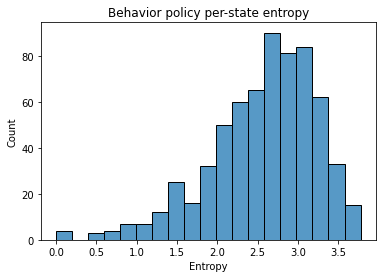

In [151]:
sns.histplot(scipy.stats.entropy(behavior_policy, axis=1))
plt.title('Behavior policy per-state entropy')
plt.xlabel('Entropy')
plt.show()

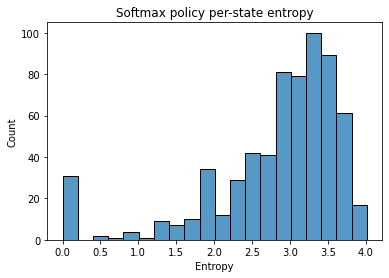

In [202]:
sns.histplot(scipy.stats.entropy(mcp_softmax, axis=1))
plt.title('Softmax policy per-state entropy')
plt.xlabel('Entropy')
plt.show()

Behavior policy argmax and greedy policy agreement: 0.04


(0.002242152466367713, 1.0)

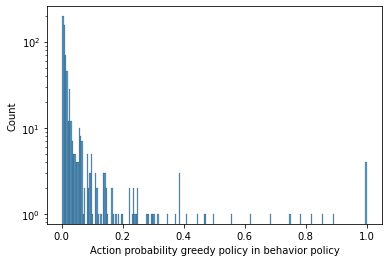

In [152]:
print("Behavior policy argmax and greedy policy agreement: {}".format((behavior_policy.argmax(axis=1) == mcp_greedy.argmax(axis=1)).sum() / n_states))
sns.histplot(behavior_policy[mcp_greedy_mask], log_scale=(False, True))
plt.xlabel('Action probability greedy policy in behavior policy')
behavior_policy[mcp_greedy_mask].min(), behavior_policy[mcp_greedy_mask].max()

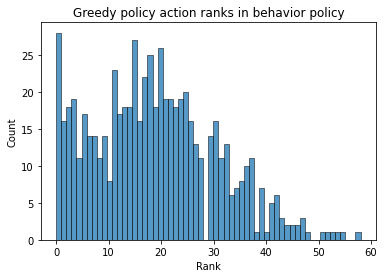

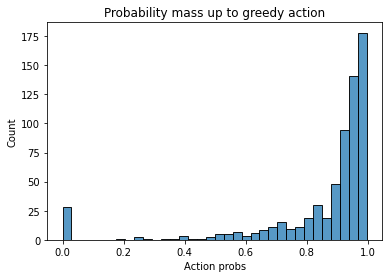

(0.0, 0.997005988023952)

In [153]:
evaluation_policy = mcp_greedy

behavior_policy_ranks = np.flip(behavior_policy.argsort(axis=1), axis=1)
ep_bp_ranks = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_ranks.append(bp_rank)

sns.histplot(ep_bp_ranks, bins=60)
plt.title('Greedy policy action ranks in behavior policy')
plt.xlabel('Rank')
plt.show()

behavior_policy_ranked_probs = np.flip(np.sort(behavior_policy, axis=1), axis=1)
ep_bp_prob_mass = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_prob_mass.append(behavior_policy_ranked_probs[s, 0:bp_rank].sum())

sns.histplot(ep_bp_prob_mass)
plt.title('Probability mass up to greedy action')
plt.xlabel('Action probs')
plt.show()
np.array(ep_bp_prob_mass).min(), np.array(ep_bp_prob_mass).max()

In [154]:
# state-values of 

In [203]:
joblib.dump(mcp_greedy, "models/mcp_greedy_policy.bin", compress=True)
joblib.dump(mcp_softmax, "models/mcp_softmax_policy.bin", compress=True)
joblib.dump(behavior_policy, "models/clinicians_policy.bin", compress=True)


['models/clinicians_policy.bin']

In [156]:
train_set[['state', 'action_discrete', 'state_action_id']]

,state,action_discrete,state_action_id
0,53,225,53-225
1,168,275,168-275
2,168,282,168-282
3,168,225,168-225
4,168,275,168-275
...,...,...,...
84552,155,337,155-337
84553,155,337,155-337
84554,155,337,155-337
84555,155,288,155-288


In [157]:
test_set[['state', 'action_discrete', 'state_action_id']]

,state,action_discrete,state_action_id
0,560,240,560-240
1,560,239,560-239
2,214,190,214-190
3,214,239,214-239
4,42,281,42-281
...,...,...,...
27289,68,141,68-141
27290,357,143,357-143
27291,379,141,379-141
27292,68,141,68-141


In [158]:
test_set

,Unnamed: 0,icustay_id,subject_id,hadm_id,intime,outtime,start_time,admission_age,gender,weight,...,action_discrete,state_action_id,next_state,sans_id,traj_count,traj_count_inv,traj_len,terminal,nterminal,reward
0,0,200003,27513,163557,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-02 17:40:00,48.296271,M,78.633331,...,240,560-240,560,560-240-560,0,17,18,False,False,0
1,1,200003,27513,163557,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-02 21:40:00,48.296271,M,78.633331,...,239,560-239,214,560-239-214,1,16,18,False,False,0
2,2,200003,27513,163557,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-03 01:40:00,48.296271,M,78.633331,...,190,214-190,214,214-190-214,2,15,18,False,False,0
3,3,200003,27513,163557,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-03 05:40:00,48.296271,M,78.633331,...,239,214-239,42,214-239-42,3,14,18,False,False,0
4,4,200003,27513,163557,2199-08-02 19:50:04,2199-08-08 17:09:18,2199-08-03 09:40:00,48.296271,M,78.633331,...,281,42-281,42,42-281-42,4,13,18,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27289,655484,299994,10718,177406,2114-12-09 11:56:00,2114-12-15 20:29:14,2114-12-11 11:55:00,74.234336,F,77.614285,...,141,68-141,357,68-141-357,13,4,18,False,False,0
27290,655485,299994,10718,177406,2114-12-09 11:56:00,2114-12-15 20:29:14,2114-12-11 15:55:00,74.234336,F,77.614285,...,143,357-143,379,357-143-379,14,3,18,False,False,0
27291,655486,299994,10718,177406,2114-12-09 11:56:00,2114-12-15 20:29:14,2114-12-11 19:55:00,74.234336,F,77.614285,...,141,379-141,68,379-141-68,15,2,18,False,False,0
27292,655487,299994,10718,177406,2114-12-09 11:56:00,2114-12-15 20:29:14,2114-12-11 23:55:00,74.234336,F,77.614285,...,141,68-141,210,68-141-210,16,1,18,False,True,0


In [ ]:
sif